In [1]:
import fastf1 as f1
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from tqdm import tqdm
sns.set()

## Qualifying Pace

In [2]:
from fastf1 import get_session as gs 
# Vegas is the 22nd GP
sessions = []
session = gs(2023,21,'Q')
session.load()
sessions.append(session)

req         WARNING 	

DEFAULT CACHE ENABLED!
	Cache directory: /Users/rafaelbeltranhernandez/Library/Caches/fastf1.
	Size: 1.1 GB
core           INFO 	Loading data for Las Vegas Grand Prix - Qualifying [v3.1.3]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['16', '55', '1', '63', '10', '23', '2', '77', '20', '14', '44', '11', '27', '18', '3', '4', 

In [3]:
from cmath import nan
def curvature(x, y):
    '''Takes the x and y coordinates and finds the curvarture per point, asuming the curve is 2-Dimensional'''
    x_t = np.gradient(x) # x_velocity
    y_t = np.gradient(y) # y_velocity
    speed = np.sqrt(x_t**2 + y_t**2)
    x_tt = np.gradient(x_t)
    y_tt = np.gradient(y_t)
    kappa = (x_tt * y_t - x_t * y_tt)/(speed**3)
    return  np.nan_to_num(abs(kappa))  

In [4]:
from scipy.stats import pearsonr as corr


dfs_correlations = [] # collection of correlation DataFrames per driver



print("*****Calculating for: " + session.event["EventName"]+ '*****')

print("Retrieving Fastest Laps...")
laps = session.laps
drivers = [i for i in laps.DriverNumber.unique()]
x = []
y = []
speed = []
gear = []
rpm = []
throttle = []
timed_drivers = []
for driver in tqdm(drivers):
    #print("Data for car" + str(driver))
    if len(laps.pick_driver(driver).index) > 3:
        try:
            fastest_lap_telemetry = laps.pick_driver(driver).pick_fastest().telemetry
        except ValueError:
            continue
        x.append(fastest_lap_telemetry.X)
        y.append(fastest_lap_telemetry.Y)
        speed.append(fastest_lap_telemetry.Speed)
        gear.append(fastest_lap_telemetry.nGear)
        rpm.append(fastest_lap_telemetry.RPM)
        throttle.append(fastest_lap_telemetry.Throttle)
        timed_drivers.append(driver)
        
        
    #print(len(x), len(y), len(speed))


# add curvature
print("Adding Curvature...")
df_curv = pd.DataFrame({"driver": timed_drivers, "X" : list(x), "Y" : list(y), "speed" : list(speed), "gear" : list(gear), "rpm" : list(rpm), "throttle" : list(throttle)})
df_curv.set_index("driver", inplace = True)
calculated_curvature = [curvature(df_curv.loc[i].X, df_curv.loc[i].Y) for i in df_curv.index]
df_curv["curvature"] = calculated_curvature


corrs = [] # remove NaN and infinite values

print("Finding Correlations...")
for driver in tqdm(df_curv.index):
    driver_lap = df_curv.loc[driver]
    lap_speed = driver_lap["speed"] 
    lap_curv = driver_lap["curvature"]
    corrs.append(corr(lap_speed,lap_curv))

df_curv["corr"] = corrs

#print("timed drivers: \n", timed_drivers, "\n Total of " + str(len(timed_drivers)) + " drivers finished the session" )
df_final = pd.DataFrame([i for i in df_curv["corr"]], index = df_curv["corr"].index, columns= ["correlation", "p_value"])

*****Calculating for: Las Vegas Grand Prix*****
Retrieving Fastest Laps...


100%|██████████| 20/20 [00:01<00:00, 13.05it/s]


Adding Curvature...
Finding Correlations...


100%|██████████| 20/20 [00:00<00:00, 1629.62it/s]


In [5]:
df_final_clean = df_final[df_final.p_value < 0.05]
df_final_clean

,correlation,p_value
driver,,
16,-0.534114,3.008208e-53
55,-0.498823,3.465985e-46
1,-0.387091,1.505539e-26
63,-0.237153,1.229849e-10
10,-0.205466,2.709561e-08
23,-0.341549,3.271650e-21
2,-0.554812,2.805289e-59
20,-0.511561,2.836028e-48
44,-0.196148,1.122476e-07


In [6]:
import dill

dill.dump_session("corr_curv.pkl")
#to restore session:
#dill.load_session('./your_bk_dill.pkl')

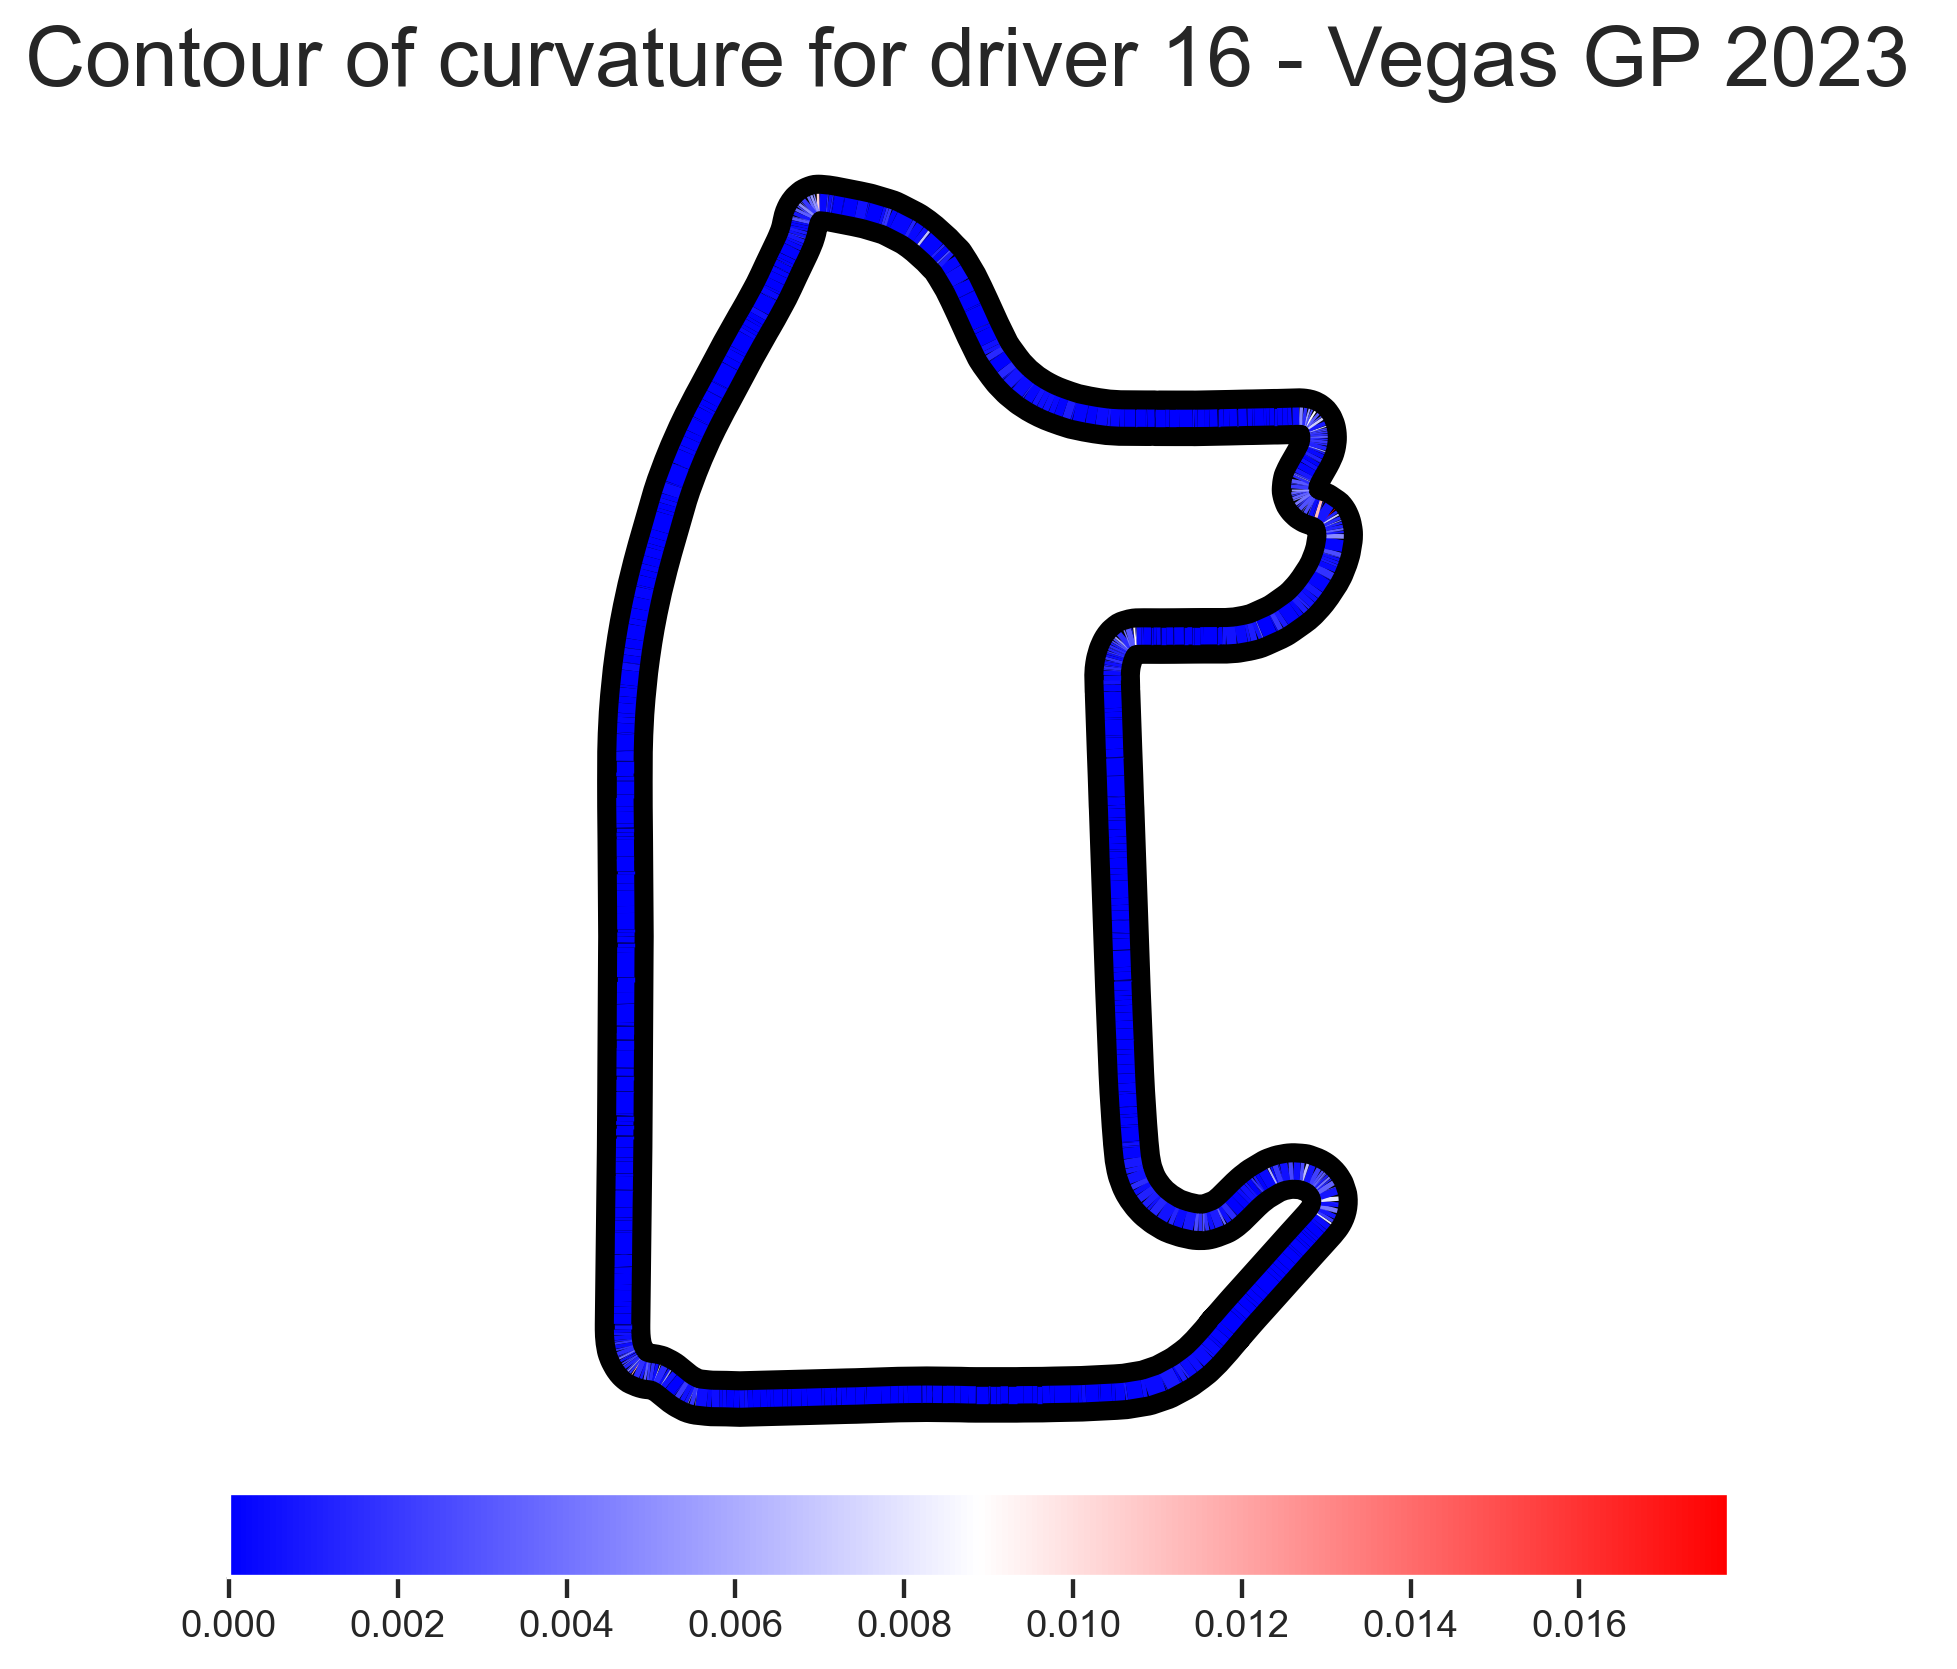

In [7]:
import matplotlib as mpl
from matplotlib.collections import LineCollection
def cont_curv(driver, feature = "curvature"):
    tele_driver = df_curv.loc[str(driver)]
    x, y = tele_driver["X"], tele_driver["Y"]
    color = tele_driver[feature]
    colormap = mpl.cm.bwr
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Plot the data

    # We create a plot with title and adjust some setting to make it look good.
    fig, ax = plt.subplots(sharex=True, sharey=True, figsize=(12, 6.75), dpi = 250)
    fig.suptitle(f'Contour of {feature} for driver {driver} - Vegas GP 2023 ', size=24, y=0.97)
    # Adjust margins and turn of axis
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.12)
    ax.axis('off')
    ax.set_aspect('equal')

    # After this, we plot the data itself.
    # Create background track line
    ax.plot(tele_driver['X'], tele_driver['Y'], color='black', linestyle='-', linewidth=16, zorder=0)

    # Create a continuous norm to mp from data points to colors

    vmax, vmin = color.max(), color.min()

    if abs(vmax) > abs(vmin):
        ref = abs(vmax)
    else:
        ref = abs(vmin)

    

    norm = plt.Normalize(vmin, vmax)
    lc = LineCollection(segments, cmap=colormap, norm=norm, linestyle='-', linewidth=5)

    # Set the values used for colormapping
    lc.set_array(color)

    # Merge all line segments together
    line = ax.add_collection(lc)


    # Finally, we create a color bar as a legend.
    cbaxes = fig.add_axes([0.25, 0.05, 0.5, 0.05])
    normlegend = mpl.colors.Normalize(vmin, vmax)
    legend = mpl.colorbar.ColorbarBase(cbaxes, norm=normlegend, cmap=colormap, orientation="horizontal")


    # Show the plot
    plt.show() 


cont_curv(16)

In [8]:
df_final_clean

,correlation,p_value
driver,,
16,-0.534114,3.008208e-53
55,-0.498823,3.465985e-46
1,-0.387091,1.505539e-26
63,-0.237153,1.229849e-10
10,-0.205466,2.709561e-08
23,-0.341549,3.271650e-21
2,-0.554812,2.805289e-59
20,-0.511561,2.836028e-48
44,-0.196148,1.122476e-07


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Curvature - Velocity Correlations for the 2023 Vegas GP')

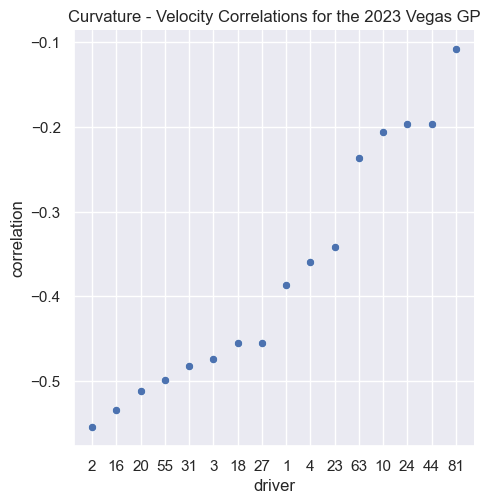

In [9]:
sns.relplot(data=df_final_clean['correlation'].sort_values())
plt.title("Curvature - Velocity Correlations for the 2023 Vegas GP")